# Imports

In [56]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    auc
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from xgboost import XGBClassifier 


# Loading data

In [2]:
features_path='data_Features.csv'
targets_path='data_Targets.csv'

In [3]:
features=pd.read_csv(features_path)
target=pd.read_csv(targets_path)

# Data Analysis and feature engineering

In [4]:
features.head()

,time,t2m,u10,v10,SST,SIC,r1_MAR,r2_MAR,r3_MAR,r4_MAR,r5_MAR
0,2013-01-01,-21.926931,-0.973994,3.149094,-1.690511,90.745710,0.034537,0.033345,0.0,0.0,0.0
1,2013-01-02,-23.696195,-6.502908,2.494894,-1.690511,88.502980,0.034527,0.033326,0.0,0.0,0.0
2,2013-01-03,-25.644027,-3.557411,1.025486,-1.689860,88.734091,0.034523,0.033321,0.0,0.0,0.0
3,2013-01-04,-23.566887,-1.888075,-3.486122,-1.690511,89.149576,0.034509,0.033306,0.0,0.0,0.0
4,2013-01-05,-22.897768,-2.748844,-3.491206,-1.689860,91.613955,0.034492,0.033290,0.0,0.0,0.0


In [5]:
features['time']=pd.to_datetime(features['time'], format='%Y-%m-%d')

In [6]:
target=target.rename(columns={'Unnamed: 0':'time'})

In [7]:
target['time']=pd.to_datetime(target['time'], format='%Y-%m-%d')

In [8]:
target['binary']=target['Y1'].apply(lambda x:x>0)

In [9]:
target

,time,Y1,Y3,Y4,Y5,binary
0,2013-01-01,0,5,0,0,False
1,2013-01-02,0,0,0,0,False
2,2013-01-03,0,0,0,0,False
3,2013-01-04,0,2,0,0,False
4,2013-01-05,0,0,0,0,False
...,...,...,...,...,...,...
2551,2019-12-27,3,0,1,0,True
2552,2019-12-28,0,0,0,0,False
2553,2019-12-29,0,0,0,0,False
2554,2019-12-30,0,0,1,0,False


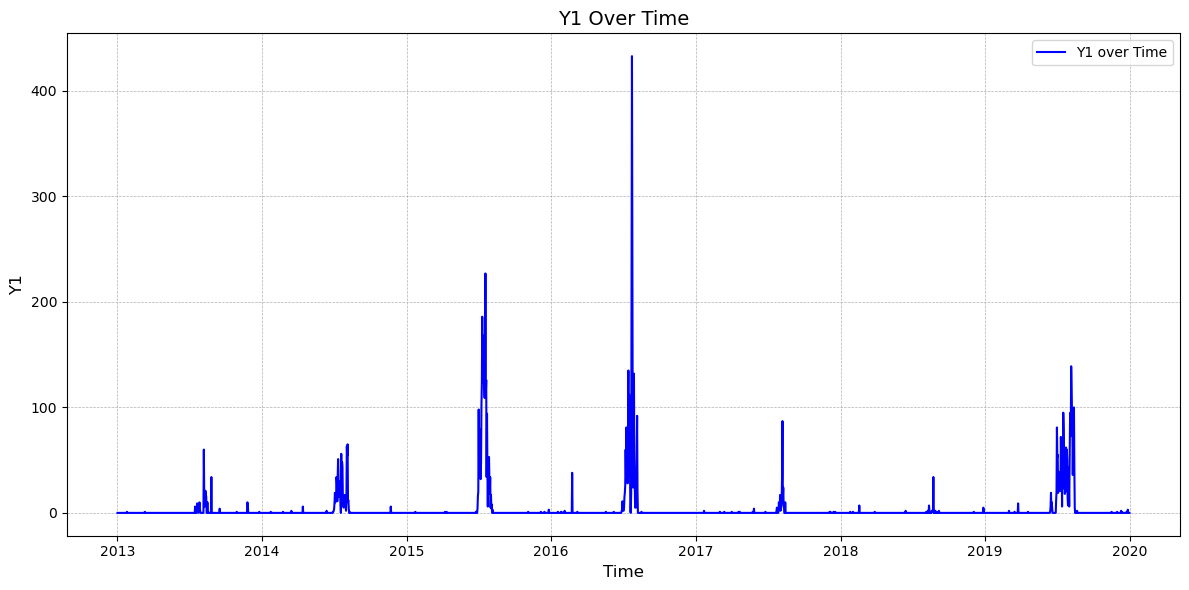

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(target['time'], target['Y1'], color='blue', linewidth=1.5, label='Y1 over Time')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Y1', fontsize=12)
plt.title('Y1 Over Time', fontsize=14)

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

plt.legend(fontsize=10)

plt.tight_layout()
plt.show()


Here we justify our threshold.

In [11]:
sum((features['time']==target['time'])*1)

2556

In [12]:
features['Y1']=target['Y1']
features['binary']=target['binary']
features['month'] = features['time'].dt.month
features['year'] = features['time'].dt.year
features['day'] = features['time'].dt.day

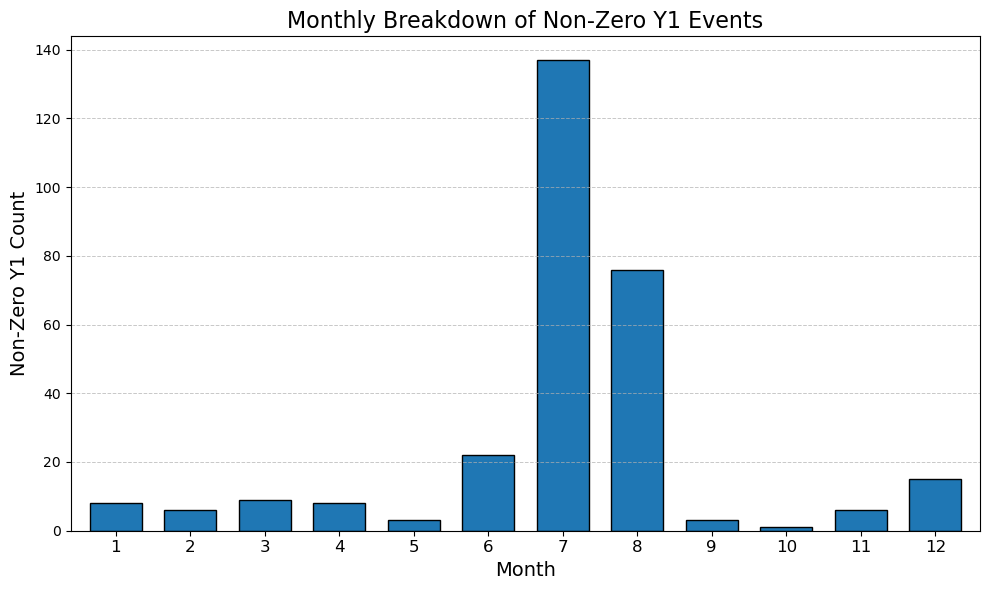

In [13]:
monthly_counts = features[features['Y1'] != 0].groupby('month')['Y1'].count()

plt.figure(figsize=(10, 6))

monthly_counts.plot(kind='bar', edgecolor='black', width=0.7)

plt.title('Monthly Breakdown of Non-Zero Y1 Events', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Non-Zero Y1 Count', fontsize=14)

plt.xticks(ticks=range(len(monthly_counts)), labels=monthly_counts.index, fontsize=12, rotation=0)

plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()

plt.show()

The month could be an important feature !

In [14]:
features.isnull().sum()

time      0
t2m       0
u10       0
v10       0
SST       0
SIC       0
r1_MAR    0
r2_MAR    0
r3_MAR    0
r4_MAR    0
r5_MAR    0
Y1        0
binary    0
month     0
year      0
day       0
dtype: int64

In [15]:
features

,time,t2m,u10,v10,SST,SIC,r1_MAR,r2_MAR,r3_MAR,r4_MAR,r5_MAR,Y1,binary,month,year,day
0,2013-01-01,-21.926931,-0.973994,3.149094,-1.690511,90.745710,0.034537,0.033345,0.0,0.0,0.0,0,False,1,2013,1
1,2013-01-02,-23.696195,-6.502908,2.494894,-1.690511,88.502980,0.034527,0.033326,0.0,0.0,0.0,0,False,1,2013,2
2,2013-01-03,-25.644027,-3.557411,1.025486,-1.689860,88.734091,0.034523,0.033321,0.0,0.0,0.0,0,False,1,2013,3
3,2013-01-04,-23.566887,-1.888075,-3.486122,-1.690511,89.149576,0.034509,0.033306,0.0,0.0,0.0,0,False,1,2013,4
4,2013-01-05,-22.897768,-2.748844,-3.491206,-1.689860,91.613955,0.034492,0.033290,0.0,0.0,0.0,0,False,1,2013,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,2019-12-27,-27.316822,1.597207,-0.091400,-1.689860,95.102792,0.466891,0.462179,0.0,0.0,0.0,3,True,12,2019,27
2552,2019-12-28,-27.998255,3.917396,0.498397,-1.690511,93.949257,0.466818,0.462108,0.0,0.0,0.0,0,False,12,2019,28
2553,2019-12-29,-23.289798,4.664877,2.332191,-1.689860,93.989076,0.417442,0.414464,0.0,0.0,0.0,0,False,12,2019,29
2554,2019-12-30,-25.674814,0.062261,3.760923,-1.689860,94.875746,0.306203,0.306203,0.0,0.0,0.0,0,False,12,2019,30


In [16]:
features.drop(columns=['time','Y1'],inplace=True)

In [17]:
features['binary']=features['binary']*1

In [18]:
features=features.rename(columns={'binary':'target'})

In [19]:
target_column = features.pop('target')  # Remove the 'target' column
features['target'] = target_column

In [20]:
features.drop(columns=['year'],inplace=True)

In [21]:
features

,t2m,u10,v10,SST,SIC,r1_MAR,r2_MAR,r3_MAR,r4_MAR,r5_MAR,month,day,target
0,-21.926931,-0.973994,3.149094,-1.690511,90.745710,0.034537,0.033345,0.0,0.0,0.0,1,1,0
1,-23.696195,-6.502908,2.494894,-1.690511,88.502980,0.034527,0.033326,0.0,0.0,0.0,1,2,0
2,-25.644027,-3.557411,1.025486,-1.689860,88.734091,0.034523,0.033321,0.0,0.0,0.0,1,3,0
3,-23.566887,-1.888075,-3.486122,-1.690511,89.149576,0.034509,0.033306,0.0,0.0,0.0,1,4,0
4,-22.897768,-2.748844,-3.491206,-1.689860,91.613955,0.034492,0.033290,0.0,0.0,0.0,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,-27.316822,1.597207,-0.091400,-1.689860,95.102792,0.466891,0.462179,0.0,0.0,0.0,12,27,1
2552,-27.998255,3.917396,0.498397,-1.690511,93.949257,0.466818,0.462108,0.0,0.0,0.0,12,28,0
2553,-23.289798,4.664877,2.332191,-1.689860,93.989076,0.417442,0.414464,0.0,0.0,0.0,12,29,0
2554,-25.674814,0.062261,3.760923,-1.689860,94.875746,0.306203,0.306203,0.0,0.0,0.0,12,30,0


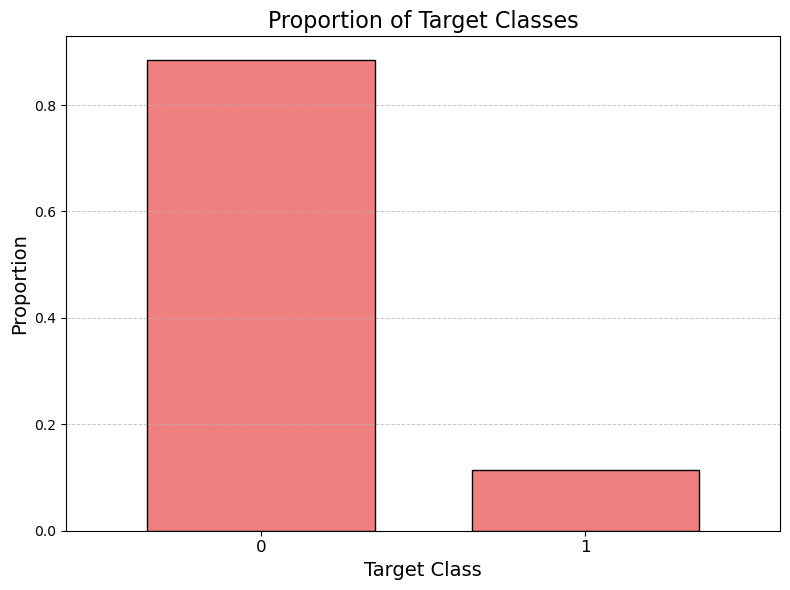

In [22]:
plt.figure(figsize=(8, 6))
features['target'].value_counts(normalize=True).plot(
    kind='bar',
    color='lightcoral',
    edgecolor='black',
    width=0.7
)

plt.title('Proportion of Target Classes', fontsize=16)
plt.xlabel('Target Class', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

plt.xticks(fontsize=12, rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()

plt.show()

Classes are unbalanced; we should keep this in mind when using machine learning models.

array([[<Axes: title={'center': 't2m'}>, <Axes: title={'center': 'u10'}>,
        <Axes: title={'center': 'v10'}>, <Axes: title={'center': 'SST'}>],
       [<Axes: title={'center': 'SIC'}>,
        <Axes: title={'center': 'r1_MAR'}>,
        <Axes: title={'center': 'r2_MAR'}>,
        <Axes: title={'center': 'r3_MAR'}>],
       [<Axes: title={'center': 'r4_MAR'}>,
        <Axes: title={'center': 'r5_MAR'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'target'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

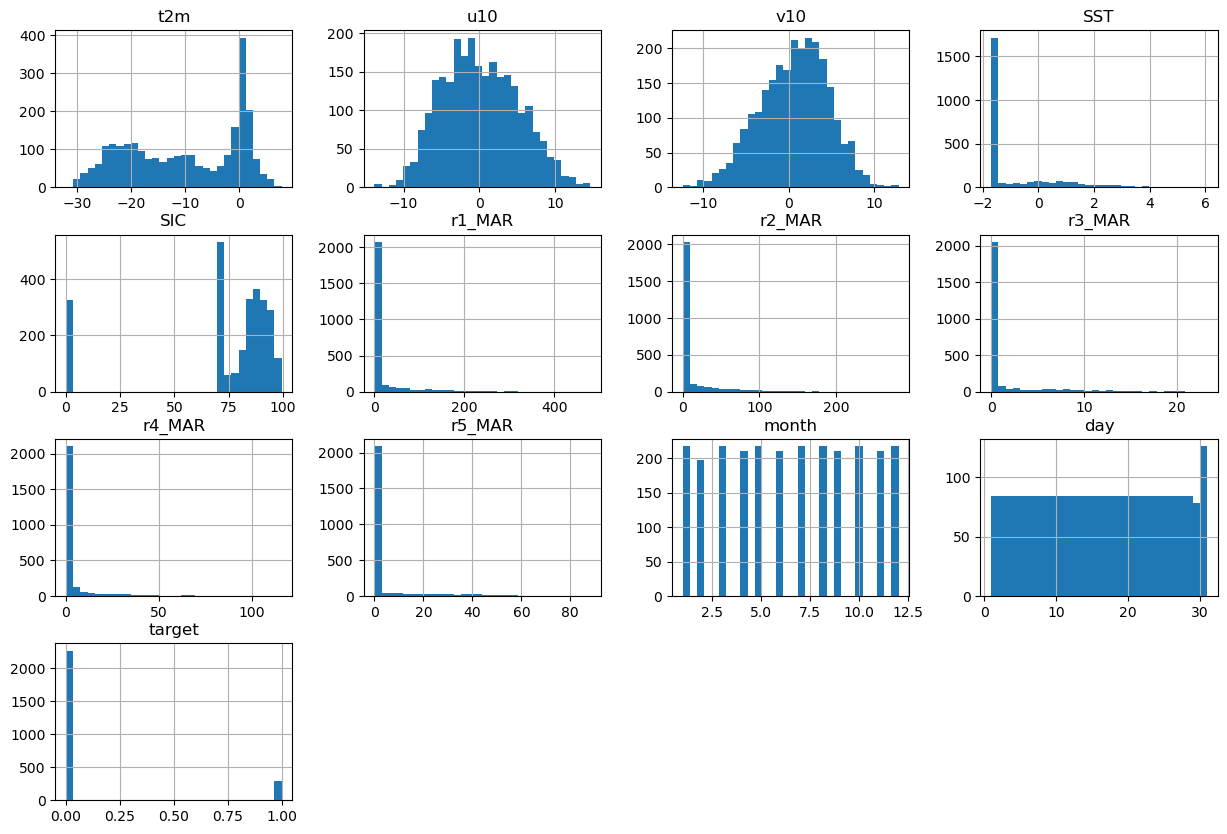

In [23]:
features.hist(bins=30, figsize=(15, 10))

For evaluation, we use the same function: evaluate_model. It estimates the real risk since we use test set which is seperate from our train.

In [24]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluates the model performance and plots a confusion matrix.

    Parameters:
        y_true (array-like): True target labels.
        y_pred (array-like): Predicted labels.
        model_name (str): Name of the model for display purposes.
    """
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    # Metrics
    report = classification_report(y_true, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_true, y_pred)
    # Display Metrics
    print(f"=== {model_name} Evaluation ===")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Precision: {report['1']['precision']:.4f}")
    print(f"Recall (Sensitivity): {report['1']['recall']:.4f}")
    print(f"F1-Score: {report['1']['f1-score']:.4f}")
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (0)', 'Rare Event (1)'],
                yticklabels=['Normal (0)', 'Rare Event (1)'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Train_Test split

In [25]:
X=features.drop(columns=['target'])
y=features['target']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y  )

In [27]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y  )
X_train, X_validation, y_train, y_validation = train_test_split(X_train_val, y_train_val,test_size=0.25,random_state=42,stratify=y_train_val)

In [28]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_validation)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1533
Validation set size: 511
Test set size: 512


# Decision tree

## Without weights balancing

In [29]:
tree = DecisionTreeClassifier( random_state=42)

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_
y_proba_validation = best_tree.predict_proba(X_validation)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_validation, y_proba_validation)

f1_scores = np.divide(
    2 * (precisions * recalls),
    (precisions + recalls),
    out=np.zeros_like(precisions),
    where=(precisions + recalls) > 0
)

optimal_idx = f1_scores.argmax()
optimal_threshold_dec_tr = thresholds[optimal_idx]

y_pred_optimal_validation = (y_proba_validation >= optimal_threshold_dec_tr).astype(int)
print("F1 Score on Validation Data:", f1_score(y_validation, y_pred_optimal_validation))

y_proba_test = best_tree.predict_proba(X_test)[:, 1]
y_pred_optimal_test = (y_proba_test >= optimal_threshold_dec_tr).astype(int)

print(f"Optimal Threshold (from Validation): {optimal_threshold_dec_tr:.2f}")
print("F1 Score on Test Data:", f1_score(y_test, y_pred_optimal_test))
print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred_optimal_test))


Fitting 3 folds for each of 72 candidates, totalling 216 fits
F1 Score on Validation Data: 0.7058823529411765
Optimal Threshold (from Validation): 0.43
F1 Score on Test Data: 0.6724137931034483
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       453
           1       0.68      0.66      0.67        59

    accuracy                           0.93       512
   macro avg       0.82      0.81      0.82       512
weighted avg       0.92      0.93      0.93       512



=== Decision tree Evaluation ===
ROC-AUC Score: 0.8106
Precision: 0.6842
Recall (Sensitivity): 0.6610
F1-Score: 0.6724
True Positives (TP): 39
True Negatives (TN): 435
False Positives (FP): 18
False Negatives (FN): 20


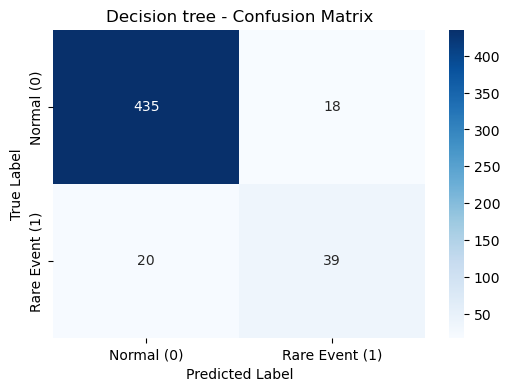

In [30]:
evaluate_model(y_test, y_pred_optimal_test, model_name="Decision tree")

In [31]:
from sklearn.tree import export_text
r = export_text(best_tree)
print(r)

|--- feature_8 <= 19.03
|   |--- feature_8 <= 7.31
|   |   |--- feature_3 <= -1.69
|   |   |   |--- feature_11 <= 24.50
|   |   |   |   |--- feature_2 <= 3.26
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_2 >  3.26
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_11 >  24.50
|   |   |   |   |--- feature_4 <= 72.22
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_4 >  72.22
|   |   |   |   |   |--- class: 0
|   |   |--- feature_3 >  -1.69
|   |   |   |--- feature_4 <= 92.08
|   |   |   |   |--- feature_2 <= -8.94
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_2 >  -8.94
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_4 >  92.08
|   |   |   |   |--- feature_0 <= -10.35
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  -10.35
|   |   |   |   |   |--- class: 0
|   |--- feature_8 >  7.31
|   |   |--- feature_11 <= 19.50
|   |   |   |--- feature_8 <= 14.10
|   |   |   |   |--- feature_3 <= 1.33
|   |   |   

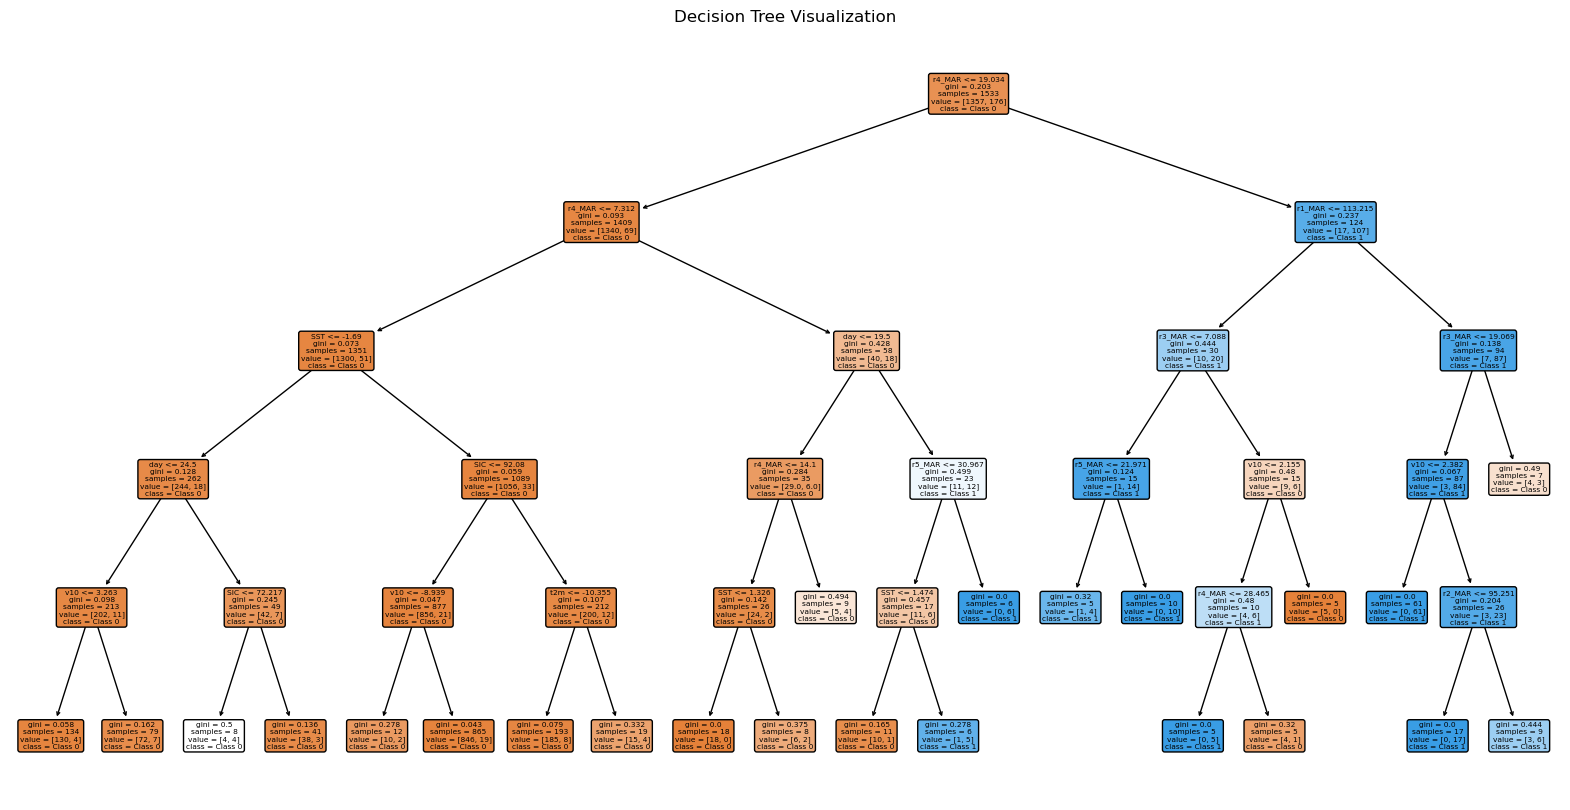

In [32]:
# Visualize the best decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=X_train.columns,
    class_names=['Class 0', 'Class 1'],
    filled=True,
    rounded=True )
plt.title("Decision Tree Visualization")
plt.show()

## With  weights balancing

In [33]:
tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_
y_proba_validation = best_tree.predict_proba(X_validation)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_validation, y_proba_validation)

f1_scores = np.divide(
    2 * (precisions * recalls),
    (precisions + recalls),
    out=np.zeros_like(precisions),
    where=(precisions + recalls) > 0
)

optimal_idx = f1_scores.argmax()
optimal_threshold_dec_tr_balanced= thresholds[optimal_idx]

y_pred_optimal_validation = (y_proba_validation >= optimal_threshold_dec_tr_balanced).astype(int)
print("F1 Score on Validation Data:", f1_score(y_validation, y_pred_optimal_validation))

y_proba_test = best_tree.predict_proba(X_test)[:, 1]
y_pred_optimal_test = (y_proba_test >= optimal_threshold_dec_tr_balanced).astype(int)

print(f"Optimal Threshold (from Validation): {optimal_threshold_dec_tr_balanced:.2f}")
print("F1 Score on Test Data:", f1_score(y_test, y_pred_optimal_test))
print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred_optimal_test))


Fitting 3 folds for each of 72 candidates, totalling 216 fits
F1 Score on Validation Data: 0.7121212121212122
Optimal Threshold (from Validation): 0.61
F1 Score on Test Data: 0.6712328767123288
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       453
           1       0.56      0.83      0.67        59

    accuracy                           0.91       512
   macro avg       0.77      0.87      0.81       512
weighted avg       0.93      0.91      0.91       512



=== Decision tree Evaluation ===
ROC-AUC Score: 0.8733
Precision: 0.5632
Recall (Sensitivity): 0.8305
F1-Score: 0.6712
True Positives (TP): 49
True Negatives (TN): 415
False Positives (FP): 38
False Negatives (FN): 10


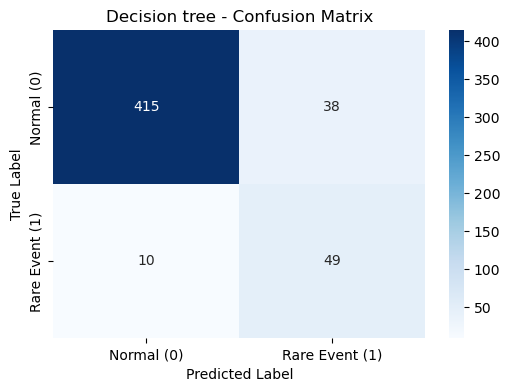

In [34]:
evaluate_model(y_test, y_pred_optimal_test, model_name="Decision tree")

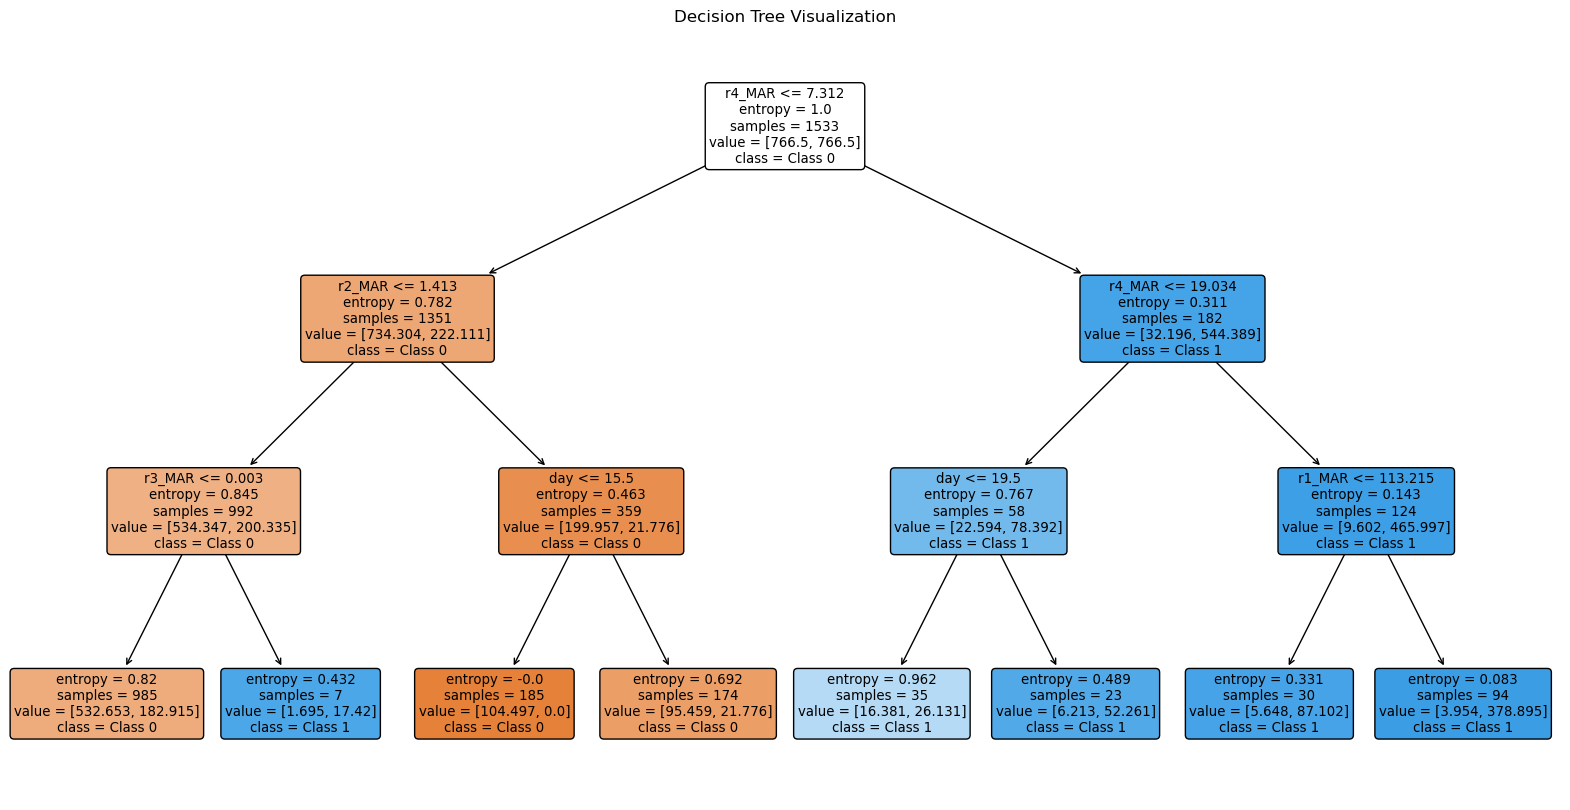

In [35]:
# Visualize the best decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=X_train.columns,
    class_names=['Class 0', 'Class 1'],
    filled=True,
    rounded=True )
plt.title("Decision Tree Visualization")
plt.show()

# Random Forest

In [41]:
forest = RandomForestClassifier(random_state=42, class_weight='balanced')  # Use balanced weights
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1 score
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_forest = grid_search.best_estimator_

y_proba_validation = best_forest.predict_proba(X_validation)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_validation, y_proba_validation)
f1_scores = np.divide(
    2 * (precisions * recalls),
    (precisions + recalls),
    out=np.zeros_like(precisions),  # Output zeros where division by zero occurs
    where=(precisions + recalls) > 0  # Only perform division where valid
)

optimal_idx = f1_scores.argmax()
optimal_threshold_rf = thresholds[optimal_idx]

y_pred_optimal_validation = (y_proba_validation >= optimal_threshold_rf).astype(int)
print("F1 Score on Validation Data:", f1_score(y_validation, y_pred_optimal_validation))

y_proba_test = best_forest.predict_proba(X_test)[:, 1]
y_pred_optimal_test = (y_proba_test >= optimal_threshold_rf).astype(int)

print(f"Optimal Threshold (from Validation): {optimal_threshold_rf:.2f}")
print("F1 Score on Test Data:", f1_score(y_test, y_pred_optimal_test))
print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred_optimal_test))


Fitting 3 folds for each of 216 candidates, totalling 648 fits
F1 Score on Validation Data: 0.7706422018348624
Optimal Threshold (from Validation): 0.76
F1 Score on Test Data: 0.7115384615384616
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       453
           1       0.82      0.63      0.71        59

    accuracy                           0.94       512
   macro avg       0.89      0.80      0.84       512
weighted avg       0.94      0.94      0.94       512



=== Random Forest Evaluation ===
ROC-AUC Score: 0.8047
Precision: 0.8222
Recall (Sensitivity): 0.6271
F1-Score: 0.7115
True Positives (TP): 37
True Negatives (TN): 445
False Positives (FP): 8
False Negatives (FN): 22


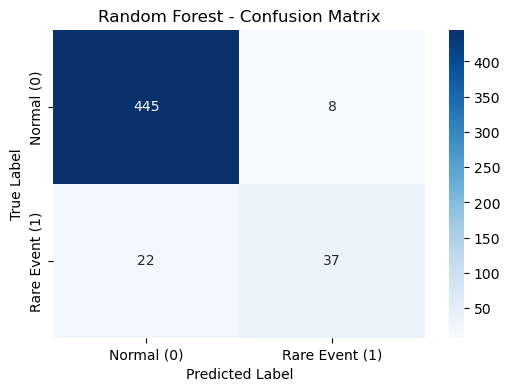

In [42]:
evaluate_model(y_test, y_pred_optimal_test, model_name="Random Forest")

## Xgboost

In [45]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1 score
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

y_proba_validation = best_xgb.predict_proba(X_validation)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_validation, y_proba_validation)

f1_scores = np.divide(
    2 * (precisions * recalls),
    (precisions + recalls),
    out=np.zeros_like(precisions),
    where=(precisions + recalls) > 0
)

optimal_idx = f1_scores.argmax()
optimal_threshold_xgb = thresholds[optimal_idx]

y_pred_optimal_validation = (y_proba_validation >= optimal_threshold_xgb).astype(int)
print("F1 Score on Validation Data:", f1_score(y_validation, y_pred_optimal_validation))

y_proba_test = best_xgb.predict_proba(X_test)[:, 1]
y_pred_optimal_test = (y_proba_test >= optimal_threshold_xgb).astype(int)

print(f"Optimal Threshold (from Validation): {optimal_threshold_xgb:.2f}")
print("F1 Score on Test Data:", f1_score(y_test, y_pred_optimal_test))
print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred_optimal_test))


Fitting 3 folds for each of 729 candidates, totalling 2187 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:51:40] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:51:40] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:51:40] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning

F1 Score on Validation Data: 0.7580645161290323
Optimal Threshold (from Validation): 0.25
F1 Score on Test Data: 0.7142857142857143
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       453
           1       0.67      0.76      0.71        59

    accuracy                           0.93       512
   macro avg       0.82      0.86      0.84       512
weighted avg       0.93      0.93      0.93       512



=== XGboost Evaluation ===
ROC-AUC Score: 0.8571
Precision: 0.6716
Recall (Sensitivity): 0.7627
F1-Score: 0.7143
True Positives (TP): 45
True Negatives (TN): 431
False Positives (FP): 22
False Negatives (FN): 14


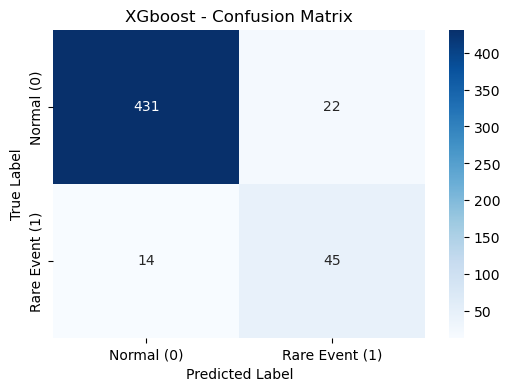

In [47]:
evaluate_model(y_test, y_pred_optimal_test, model_name="XGboost")

# Extra Trees

In [48]:
extra_trees = ExtraTreesClassifier(random_state=42, class_weight='balanced')  # Add class balancing

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=extra_trees,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1      )
grid_search.fit(X_train, y_train)

best_extra_trees = grid_search.best_estimator_

y_proba_validation = best_extra_trees.predict_proba(X_validation)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_validation, y_proba_validation)

f1_scores = np.divide(
    2 * (precisions * recalls),
    (precisions + recalls),
    out=np.zeros_like(precisions),
    where=(precisions + recalls) > 0
)

optimal_idx = f1_scores.argmax()
optimal_threshold_et = thresholds[optimal_idx]

y_pred_optimal_validation = (y_proba_validation >= optimal_threshold_et).astype(int)
print("F1 Score on Validation Data:", f1_score(y_validation, y_pred_optimal_validation))

y_proba_test = best_extra_trees.predict_proba(X_test)[:, 1]
y_pred_optimal_test = (y_proba_test >= optimal_threshold_et).astype(int)

print(f"Optimal Threshold (from Validation): {optimal_threshold_et:.2f}")
print("F1 Score on Test Data:", f1_score(y_test, y_pred_optimal_test))
print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred_optimal_test))


Fitting 3 folds for each of 216 candidates, totalling 648 fits
F1 Score on Validation Data: 0.7678571428571429
Optimal Threshold (from Validation): 0.66
F1 Score on Test Data: 0.7407407407407407
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       453
           1       0.82      0.68      0.74        59

    accuracy                           0.95       512
   macro avg       0.89      0.83      0.86       512
weighted avg       0.94      0.95      0.94       512



=== Extra Trees Evaluation ===
ROC-AUC Score: 0.8290
Precision: 0.8163
Recall (Sensitivity): 0.6780
F1-Score: 0.7407
True Positives (TP): 40
True Negatives (TN): 444
False Positives (FP): 9
False Negatives (FN): 19


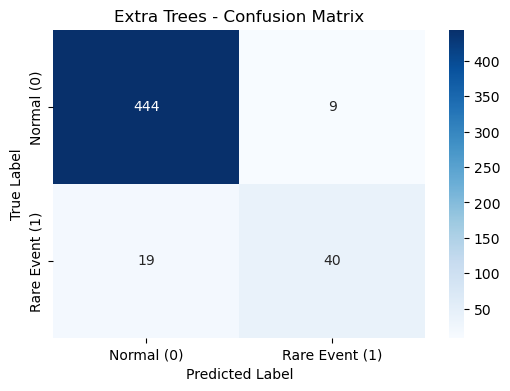

In [49]:
evaluate_model(y_test, y_pred_optimal_test, model_name="Extra Trees")

In [50]:
y_proba_test = best_tree.predict_proba(X_test)[:, 1]
y_pred_optimal_test_decision_tree = (y_proba_test >= optimal_threshold_dec_tr_balanced).astype(int)


y_proba_test = best_forest.predict_proba(X_test)[:, 1]
y_pred_optimal_test_random_forest = (y_proba_test >= optimal_threshold_rf).astype(int)


y_proba_test = best_xgb.predict_proba(X_test)[:, 1]
y_pred_optimal_test_xgb = (y_proba_test >= optimal_threshold_xgb).astype(int)

y_proba_test = best_extra_trees.predict_proba(X_test)[:, 1]
y_pred_optimal_test_ext_tree = (y_proba_test >= optimal_threshold_et).astype(int)


# Conclusin

In [57]:
def compare_models_fixed(y_test, y_proba_tests, thresholds, model_names):
    """
    Compare multiple models based on recall, precision, F1 score, and PR AUC.

    Parameters:
    y_test (array-like): Ground truth labels for the test set.
    y_proba_tests (dict): Dictionary of model names as keys and predicted probabilities as values.
    thresholds (dict): Dictionary of model names as keys and optimal thresholds as values.
    model_names (list): List of model names for comparison.

    Returns:
    pd.DataFrame: DataFrame containing the evaluation metrics for each model.
    """
    performance_data = []

    for model in model_names:
        # Get predicted probabilities and threshold for the current model
        y_proba = y_proba_tests[model]
        threshold = thresholds[model]

        # threshold
        y_pred_optimal = (y_proba >= threshold).astype(int)

        # metrics
        precision = precision_score(y_test, y_pred_optimal)
        recall = recall_score(y_test, y_pred_optimal)
        f1 = f1_score(y_test, y_pred_optimal)

        # PR AUC
        precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recalls, precisions)

        performance_data.append({
            'Model': model,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'PR AUC': pr_auc
        })

    performance_df = pd.DataFrame(performance_data).set_index('Model')

    return performance_df

y_proba_tests = {
    'Decision Tree': best_tree.predict_proba(X_test)[:, 1],
    'Random Forest': best_forest.predict_proba(X_test)[:, 1],
    'XGBoost': best_xgb.predict_proba(X_test)[:, 1],
    'Extra Trees': best_extra_trees.predict_proba(X_test)[:, 1]
}

thresholds = {
    'Decision Tree': optimal_threshold_dec_tr_balanced,
    'Random Forest': optimal_threshold_rf,
    'XGBoost': optimal_threshold_xgb,
    'Extra Trees': optimal_threshold_et
}

model_names = ['Decision Tree', 'Random Forest', 'XGBoost', 'Extra Trees']

performance_df = compare_models_fixed(y_test, y_proba_tests, thresholds, model_names)
performance_df



,Precision,Recall,F1 Score,PR AUC
Model,,,,
Decision Tree,0.563218,0.830508,0.671233,0.771337
Random Forest,0.822222,0.627119,0.711538,0.794131
XGBoost,0.671642,0.762712,0.714286,0.770879
Extra Trees,0.816327,0.677966,0.740741,0.802858
